# Import libraries

Import libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import seaborn as sns


# Obtain Data

Read csv data to pandas

In [4]:
df = pd.read_csv('nba_draft_combine.csv')
df.head()

,Unnamed: 0,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,0,Blake Griffin,2009,1.0,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,1,Terrence Williams,2009,11.0,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,2,Gerald Henderson,2009,12.0,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,3,Tyler Hansbrough,2009,13.0,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,4,Earl Clark,2009,14.0,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35


# Scrub Data

Create df.info overview of missing values and data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                517 non-null    int64  
 1   Player                    517 non-null    object 
 2   Year                      517 non-null    int64  
 3   Draft pick                384 non-null    float64
 4   Height (No Shoes)         517 non-null    float64
 5   Height (With Shoes)       516 non-null    float64
 6   Wingspan                  517 non-null    float64
 7   Standing reach            517 non-null    float64
 8   Vertical (Max)            450 non-null    float64
 9   Vertical (Max Reach)      450 non-null    float64
 10  Vertical (No Step)        450 non-null    float64
 11  Vertical (No Step Reach)  450 non-null    float64
 12  Weight                    516 non-null    float64
 13  Body Fat                  514 non-null    float64
 14  Hand (Leng

Drop df columns not relevant for clustering

In [6]:
df.drop(columns=['Unnamed: 0','Player','Year','Draft pick'], inplace=True)

Create correlation heatmap to find columns to remove

[Text(32.99999999999999, 0.5, 'Positions'),
 Text(0.5, 15.0, 'Positions'),
 Text(0.5, 1, 'NBA Draft Combine Measurements Correlation Heatmap')]

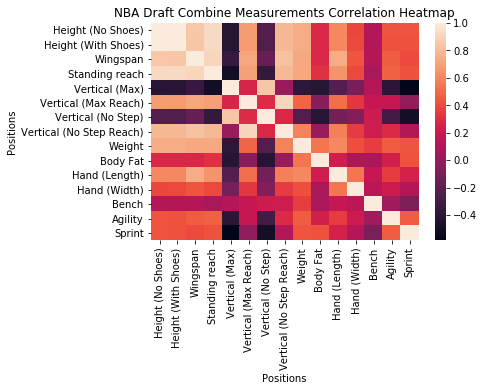

In [7]:
corr_matrix = df.corr()
heatmap = sns.heatmap(corr_matrix)
heatmap.set(Title='NBA Draft Combine Measurements Correlation Heatmap', xlabel='Positions', ylabel='Positions')


Drop correlated columns

In [8]:
df.drop(columns=['Bench','Height (With Shoes)', 'Vertical (Max Reach)', 'Vertical (No Step)',
                 'Vertical (No Step Reach)','Standing reach'], inplace=True)
df.dropna(inplace=True)

df.info to confirm that data has been scrubbed

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 15 to 516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Height (No Shoes)  394 non-null    float64
 1   Wingspan           394 non-null    float64
 2   Vertical (Max)     394 non-null    float64
 3   Weight             394 non-null    float64
 4   Body Fat           394 non-null    float64
 5   Hand (Length)      394 non-null    float64
 6   Hand (Width)       394 non-null    float64
 7   Agility            394 non-null    float64
 8   Sprint             394 non-null    float64
dtypes: float64(9)
memory usage: 30.8 KB


# Explore Data

Create heatmap of correlations in scrubbed ata

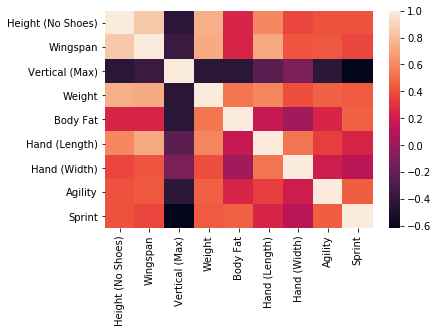

In [10]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)

Calculate descriptive statistics for the df

In [11]:
df.describe()

,Height (No Shoes),Wingspan,Vertical (Max),Weight,Body Fat,Hand (Length),Hand (Width),Agility,Sprint
count,394.000000,394.000000,394.00000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,77.544416,82.486294,35.26269,214.492386,7.136548,8.715228,9.394670,11.348122,3.305381
std,3.271085,3.841678,3.65951,24.219127,2.376782,0.469932,0.736203,0.570065,0.129330
min,68.250000,70.750000,25.00000,149.000000,3.200000,7.500000,7.000000,10.070000,3.010000
25%,75.250000,79.812500,32.50000,197.000000,5.400000,8.500000,9.000000,10.950000,3.210000
50%,77.750000,82.500000,35.50000,213.000000,6.600000,8.750000,9.500000,11.280000,3.280000
75%,80.000000,85.437500,37.50000,231.000000,8.175000,9.000000,9.750000,11.680000,3.387500
max,85.250000,92.500000,44.50000,302.000000,16.400000,10.000000,12.000000,13.440000,3.810000


Create distribution plots for each of the features in the dataset

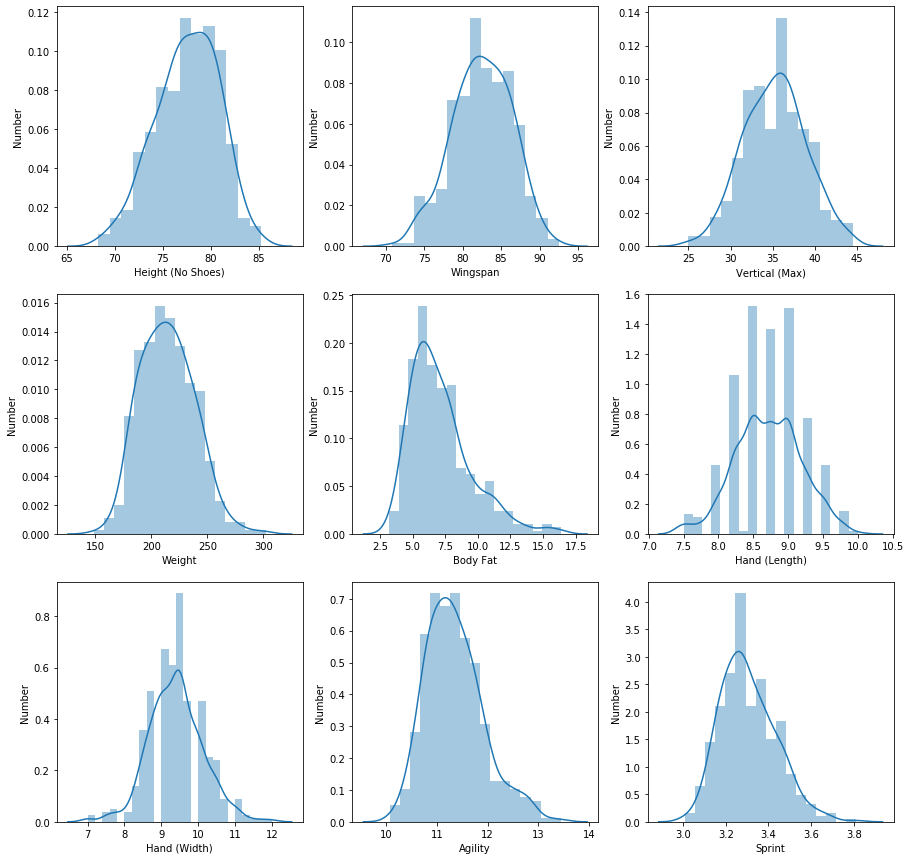

In [12]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
for index, col in enumerate(df.columns):
    sns.distplot(df[col], ax = ax[index//3][index%3])
    ax[index//3][index%3].set_ylabel('Number')

# Model Data

Standardize data for cluster modeling

In [13]:
ss = StandardScaler()
ss.fit(df)
x = ss.transform(df)
x

array([[ 0.21597756,  0.5899984 ,  0.47534192, ..., -1.21679475,
        -0.20747095, -1.66747803],
       [-0.24316898, -0.84348802, -1.98713062, ..., -0.1967583 ,
        -0.38311245,  1.351903  ],
       [ 0.67512411,  0.39452298, -0.20867823, ...,  0.82327815,
         1.02201956,  0.26802263],
       ...,
       [-0.93188881, -0.45253718,  1.43297013, ...,  0.82327815,
         1.12740446, -0.04165748],
       [ 0.29250199, -1.42991428, -0.61909032, ..., -0.1967583 ,
         1.84753461,  1.73900313],
       [ 0.21597756, -0.06158633,  0.47534192, ..., -0.53677045,
        -0.2952917 , -0.35133758]])

Create elbow plot for k means clustering of dataset

Text(0, 0.5, 'Sum of Squared Distances')

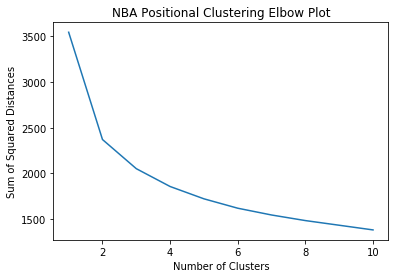

In [14]:
elbow_values = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x)
    elbow_values.append([k, kmeans.inertia_])
elbow_df = pd.DataFrame(elbow_values, columns = ['K','Inertia'])
fig, ax = plt.subplots()
ax.plot(elbow_df['K'], elbow_df['Inertia'])
ax.set_title('NBA Positional Clustering Elbow Plot')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Sum of Squared Distances')

Create plot of Silhouette Scores for each k value in k means clustering

Text(0, 0.5, 'Silhouette Score')

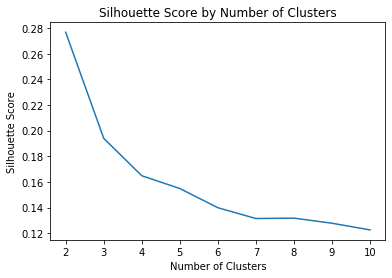

In [15]:
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x)
    labels = kmeans.labels_
    sil_score = silhouette_score(x, labels)
    silhouette_scores.append([k, sil_score])
sil_df = pd.DataFrame(silhouette_scores, columns = ['K','Silhouette Score'])
fig, ax = plt.subplots()
ax.plot(sil_df['K'], sil_df['Silhouette Score'])
ax.set_title('Silhouette Score by Number of Clusters')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

Create Dendrogram for Hierarchical Agglomerative Clustering of dataset

Text(0, 0.5, 'Distance')

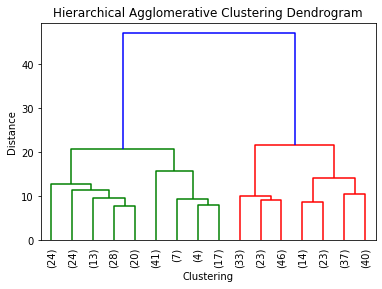

In [16]:
link = linkage(x, 'ward')
dendrogram(link, truncate_mode='lastp', p=16, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Agglomerative Clustering Dendrogram')
plt.xlabel('Clustering')
plt.ylabel('Distance')

Fit t-sne model to data

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_output = tsne.fit_transform(x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 394 samples in 0.001s...
[t-SNE] Computed neighbors for 394 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 394 / 394
[t-SNE] Mean sigma: 1.092493
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.313599
[t-SNE] KL divergence after 500 iterations: 0.866655


Create df of t-sne output

In [22]:
tsne_df = pd.DataFrame(tsne_output, columns = ['d1', 'd2'])
tsne_df.head()

,d1,d2
0,4.989259,2.935926
1,-9.867348,-1.350689
2,2.259804,-4.924499
3,4.420640,-8.873199
4,-8.649923,9.005141


Build K Means Clustering model to apply labels to datapoints in t-sne scatterplot

In [30]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x)
hue_labels = kmeans.labels_

Build t-sne plot of data

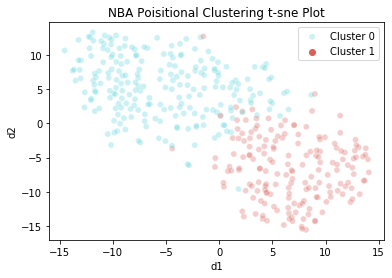

In [43]:
tsne_plot = sns.scatterplot(
    x="d1", y="d2",
    hue=hue_labels,
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.3)
tsne_plot.set_title('NBA Poisitional Clustering t-sne Plot')
tsne_plot.legend(['Cluster 0', 'Cluster 1'])